In [1]:
import os
os.chdir('/home/holzschuh/projects/cursor/pde-transformer')

## Initialize PDE-S with pretrained weights from huggingface

In [2]:
from pdetransformer.core.mixed_channels import PDETransformer, SingleStepSupervised
import torch

# Load pre-trained model
model = PDETransformer.from_pretrained('thuerey-group/pde-transformer', subfolder='mc-l').cuda()
strategy = SingleStepSupervised(model)

/home/holzschuh/anaconda3/envs/diffusion/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/holzschuh/anaconda3/envs/diffusion/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/holzschuh/anaconda3/envs/diffusion/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## Load dataset 

In [3]:
from pdetransformer.data import MultiDataModule

dataset = 'kolm_flow'
dataset_name = 'Kolmogorov Flow'
field = 'Vorticity'

params_data = {
    'path_index':
        {'2D_APE_xxl': './datasets'},
    'dataset_names': [ dataset ],
    'dataset_type': '2D_APE_xxl',
    'unrolling_steps': 1,
    'test_unrolling_steps': 29,
    'batch_size': 1,
    'num_workers': 1,
    'cache_strategy': 'none',
    'different_resolution_strategy': 'none',
    'normalize_data': 'mean-std',
    'normalize_const': 'mean-std',
    'downsample_factor': 1,
    'max_channels': 2,
}

data_module = MultiDataModule(**params_data)
data_module.setup(stage='test')
test_loader = data_module.test_dataloader()

dict_keys(['diff', 'kdv', 'hyp', 'kolm_flow', 'ks_test', 'gs_alpha_test', 'ks', 'fisher', 'kolm_flow_test', 'gs_alpha', 'burgers'])
Success: Loaded kolm_flow with 60 simulations and 29 samples each.
dict_keys(['diff', 'kdv', 'hyp', 'kolm_flow', 'ks_test', 'gs_alpha_test', 'ks', 'fisher', 'kolm_flow_test', 'gs_alpha', 'burgers'])
Success: Loaded kolm_flow_test with 5 simulations and 1 samples each.


In [4]:
data = next(iter(test_loader))
prediction, reference = strategy.predict(data, device=torch.device('cuda'), num_frames=29)

100%|███████████████████████████████████████████| 28/28 [00:01<00:00, 22.02it/s]


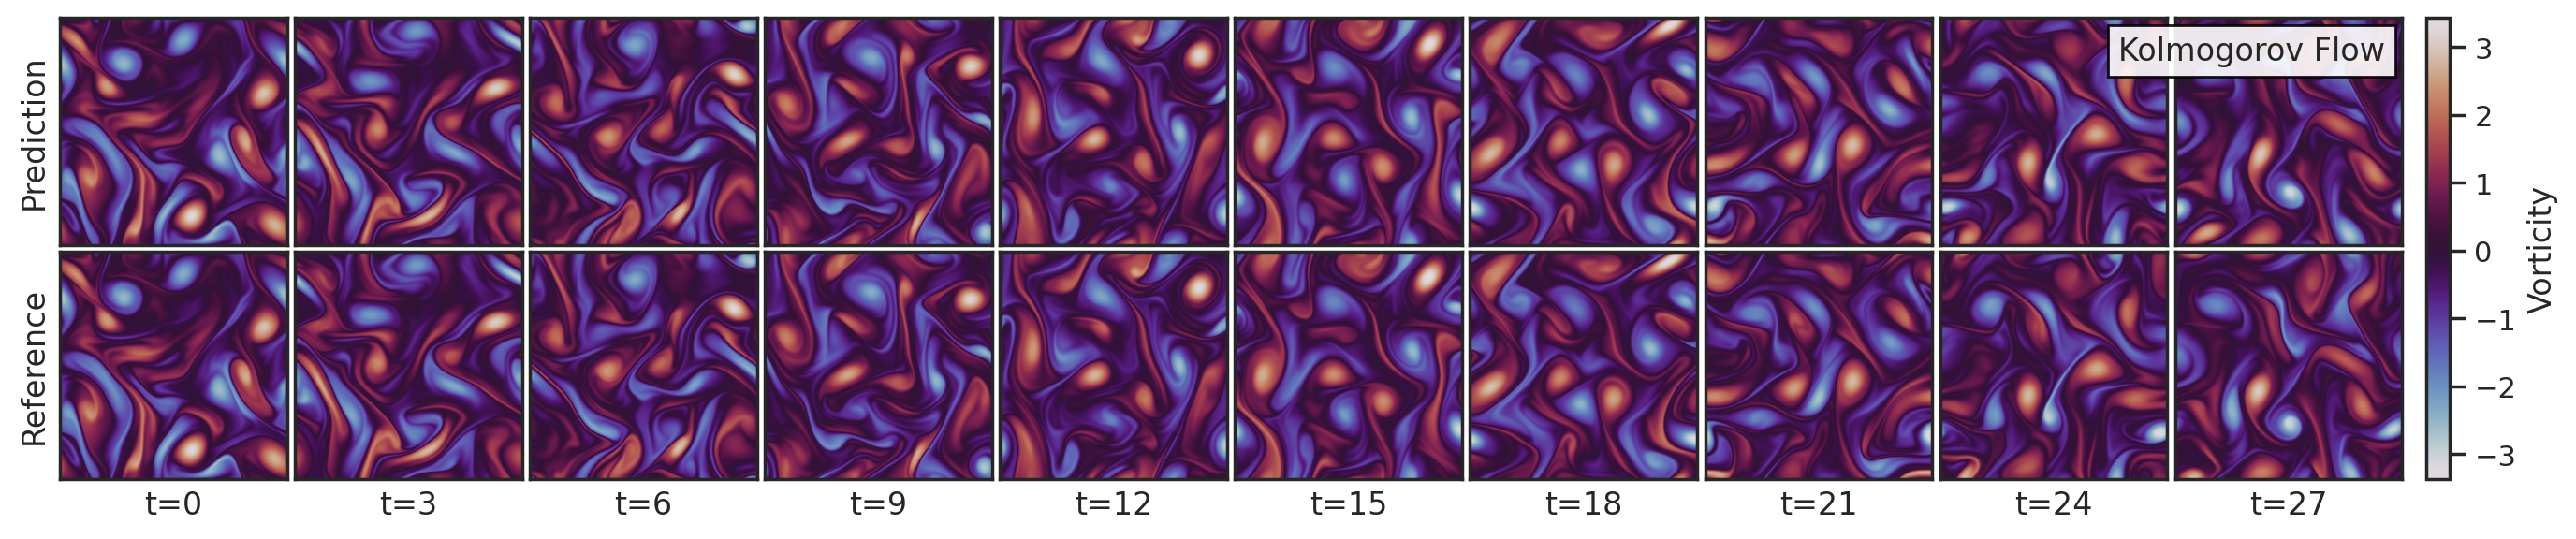

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns

time_steps = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27]

prediction_steps = prediction[0, :, :, :]
reference_steps = reference[0, :, :, :]

sns.set_theme(style="white")
cmap = sns.color_palette("twilight", as_cmap=True)

fig, axes = plt.subplots(2, len(time_steps), figsize=(16.65,3.2), dpi=200)

vmin = reference_steps.min()
vmax = reference_steps.max()

for j, t in enumerate(time_steps):

    axes[0, j].imshow(prediction_steps[t][0],  cmap=cmap, vmin=vmin, vmax=vmax)

    axes[0, j].set_xticks([])
    axes[0, j].set_yticks([])

    axes[1, j].imshow(reference_steps[t][0], cmap=cmap,
                        vmin=vmin, vmax=vmax)

    axes[1, j].set_xticks([])
    axes[1, j].set_yticks([])

axes[0, 0].set_ylabel('Prediction', fontsize=12)
axes[1, 0].set_ylabel('Reference', fontsize=12)

for j, t in enumerate(time_steps):
    axes[1, j].set_xlabel(f't={t}', fontsize=12)

fig.text(0.8712, 0.85, f'{dataset_name}',
            fontsize=12, ha='right', va='top', bbox=dict(facecolor='white', alpha=0.9, edgecolor='black'))

plt.subplots_adjust(wspace=0.03, hspace=0.03)

cbar = fig.colorbar(axes[0, 0].images[0], ax=axes, orientation='vertical', fraction=0.02, pad=0.01)
cbar.set_label(field, fontsize=12)

## Model input for single step

In [6]:
input_0, input_1, labels = strategy.get_input(data)

In [7]:
labels

tensor([16])

Class label 16 corresponds to Kolmogorov flow

In [8]:
print('input_0: ', input_0.shape)
print('input_1: ', input_1.shape)

input_0:  torch.Size([1, 2, 256, 256])
input_1:  torch.Size([1, 29, 2, 256, 256])


We can also drop the class label and let the modle infer the type of PDE by itself

In [18]:
labels_unknown = torch.ones_like(labels) * 1000

In [19]:
with torch.no_grad():

    output_kolm_flow = model(
        hidden_states=input_0.cuda(),
        class_labels=labels.cuda()
    )
    
    output_unknown = model(
        hidden_states=input_0.cuda(),
        class_labels=labels_unknown.cuda()
    )

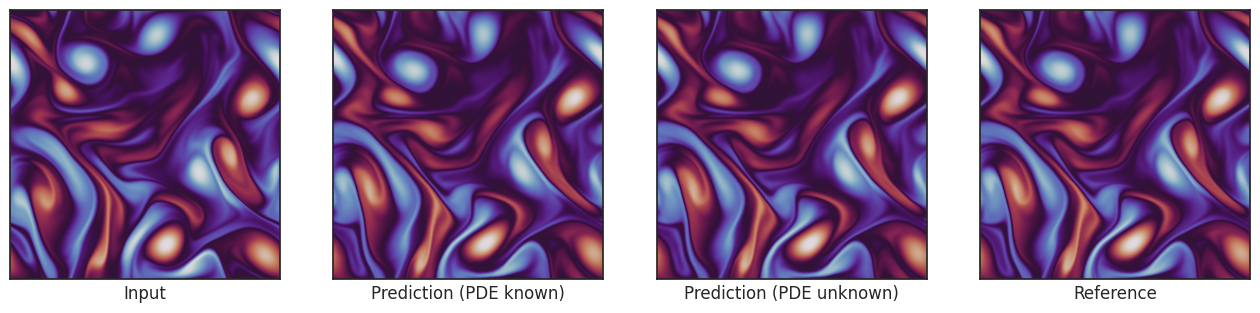

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4))

vmin = input_0.min()
vmax = input_1.max()

axes[0].imshow(input_0[0,0].numpy(), cmap='twilight')
axes[0].set_xlabel('Input')

axes[1].imshow(output_kolm_flow.sample[0,0].detach().cpu().numpy(), cmap='twilight')
axes[1].set_xlabel('Prediction (PDE known)')

axes[2].imshow(output_unknown.sample[0,0].detach().cpu().numpy(), cmap='twilight')
axes[2].set_xlabel('Prediction (PDE unknown)')

axes[3].imshow(input_1[0,0,0].numpy(), cmap='twilight')
axes[3].set_xlabel('Reference')

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])